In [2]:
%%capture
!pip install torch==2.0.0 torchvision==0.15.1
!pip install d2l==1.0.3

In [3]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# d2l - Chapter 10.7

## The task | dataset

[Dataset description](https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html)
* Download
* Preprocess
* Tokenize (world-level)

In [4]:
data = d2l.MTFraEng(batch_size=128)
# Note: label: the decoder input shifted by 1
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src[0:3].type(torch.int32))
print('decoder input:', tgt[0:3].type(torch.int32))
print('source len excluding pad:', src_valid_len[0:3].type(torch.int32))
print('label:', label[0:3].type(torch.int32))

source: tensor([[151, 174,   0,   3,   4,   4,   4,   4,   4],
        [ 84,   5,   2,   3,   4,   4,   4,   4,   4],
        [181, 175,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3,   6, 151,  89,   0,   4,   5,   5,   5],
        [  3, 111,   6,   2,   4,   5,   5,   5,   5],
        [  3,   6,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[  6, 151,  89,   0,   4,   5,   5,   5,   5],
        [111,   6,   2,   4,   5,   5,   5,   5,   5],
        [  6,   0,   4,   5,   5,   5,   5,   5,   5]], dtype=torch.int32)


## Encoder-decoder architecture

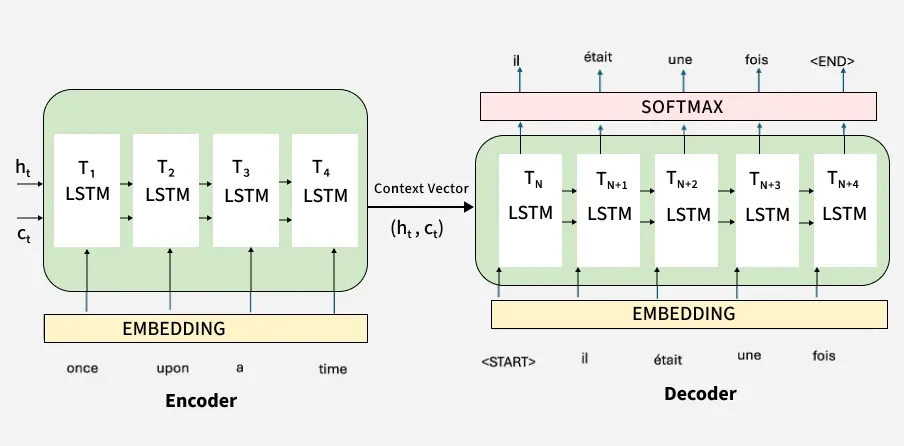![image.png]

#### Encoder

* Embedded input sequence: $x_t$
* Encoder's RNN's hidden state: $h_t$

$$
h_t = f_{enc}(h_{t-1}, x_t) = \text{tanh}\left(
W_x x_t + W_h h_{t-1} + b
\right)
$$

The context vector $c$ is given by

$$
c = q(h_1, \dots, h_T) = h_T
$$

In [5]:
# https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html#sec-encoder-decoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X, *args):
        raise NotImplemented

In [6]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [7]:
class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        """
        Args:
            vocab_size: size of the input vocabulary
            embed_size: embedding size
            num_hiddens: number of features in the hidden state
            num_layers: number of recurrent layers (num_layers=2: stack two GRUs together => stacked GRU)
            dropout: dropout layer on the outputs of each GRU layer except the last
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        #self.rnn = nn.GRU(input_size=embed_size, hidden_size=num_hiddens, num_layers=num_layers, dropout=dropout)
        self.rnn = d2l.GRU(num_inputs=embed_size, num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # Embed the input sequence.
        #  X shape: (batch_size, num_steps)
        #  Why num_steps? => The forward() does a _full pass_ through the RNN!
        #    1) batch_size: number of independent sequences being processed simultaneously.
        #    2) num_steps: length of each sequence in the batch. It represents the number of tokens (for example words)
        #                  in a given sequence.        
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int64))
        
        # #https://docs.pytorch.org/docs/stable/generated/torch.nn.GRU.html
        # NOTE: GRU: expects the input shape to be:
        #    Expected shape of input tensor: (sequence_length, batch_size, input_size <=> embedding size)
        #    Output:
        #      outputs: all hidden states 
        #      state: 
        # outputs shape: (num_steps,  batch_size, num_hiddens)
        # state shape:   (num_layers, batch_size, num_hiddens)
        # When you only provide the input sequence to a PyTorch $\text{GRU}$ or $\text{RNN}$ (self.rnn(input)), 
        # the module automatically assumes the initial hidden state ($\mathbf{h}_0$) should be a tensor of zeros.
        outputs, state = self.rnn(embs)
        
        return outputs, state
        

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)  # Note: enc_outputs[-1] == enc_state[1]
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

#### Decoder


* Target output sequence (embedded): $y_t$. 
* Encoder's RNN's hidden state: $s_k$

$$
s_k = f_{dec}(s_{k-1}, c, y_{k-1}) = \text{tanh}\left(
W_x y_{k-1} + W_h h_{k-1} + W_c c + b
\right)
$$

NOTE: How does the prediction work based on the hidden state?

$$
p(y_{t}) = \text{softmax}(Ws_t + b),
$$

where $W$ is of dimension (num_hiddens, vocabulary_size).


In [8]:
class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # We add an additional init_state method to convert the encoder output (enc_all_outputs) 
    # into the encoded state. 
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [9]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # We concatenate the context vector c and the (last) hidden state of the encoder's RNN.
        num_inputs = embed_size+num_hiddens
        self.rnn = d2l.GRU(num_inputs, num_hiddens,num_layers, dropout)

        # This layer does: W s_t + b, where W = (num_inputs, vocabulary_size)
        # Outputs logits | softmax is incorporated into the loss function that is applied after the decoder runs
        self.dense = nn.LazyLinear(vocab_size)  
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, Y, state):
        embs = self.embedding(Y.t().type(torch.int64))
        
        # All hidden states of the last layer, the last hidden state (for all layers)
        # See d2l.EncoderDecoder why state contains what it does.
        enc_output, enc_last_hidden_state = state  
        context = enc_output[-1]

        # Remember: tanh[ W_x y_{k-1} + W_h h_{k-1} + W_c c + b ] = tanh[ W_x y_{k-1} + W [h_{k-1] c] + b]
        context = context.repeat(embs.shape[0], 1, 1)
        
        embs_and_context = torch.cat((embs, context), -1)
        initial_hidden_state = enc_last_hidden_state
        outputs, enc_last_hidden_state = self.rnn(embs_and_context, initial_hidden_state)        

        # self.dense = nn.LazyLinear(vocab_size)
        # It transforms the recurrent hidden states into unnormalized logit scores over the entire vocabulary.
        # Why do we create logits for all outputs = all topmost layer hidden states of the decoder?
        #  => At each time step, the decoder predicts a probability distribution for the output tokens
        #  => See teacher fostering for training
        outputs = self.dense(outputs).swapaxes(0, 1)

        return outputs, [enc_output, enc_last_hidden_state]

decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))                

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Encoder–Decoder for Sequence-to-Sequence Learning


In [10]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [26]:
class EncoderDecoder(d2l.Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        # enc_X is the input sequence
        # dec_X is the target sequence

        # Encoder
        enc_all_outputs = self.encoder(enc_X, *args)  # returns enc_outputs, enc_hidden_state = self.rnn(embs)

        # Decoder
        dec_state = self.decoder.init_state(enc_all_outputs, *args)  # returns simply enc_all_outputs ATM
        
        # Return decoder output only
        #   Runs decoder.forward(dec_X=Y, state)
        #      outputs = topmost layer's last_hidden_states of decoder's RNN
        #      outputs = self.dense(outputs): create logits
        dec_output = self.decoder(dec_X, dec_state)[0]  # dec_output = logits of y_hat with size |V|
        return dec_output


    from typing import Tuple, Any
    def predict_step(self, batch: Tuple[Any, ...], device, num_steps, save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        src_seq, target_seq, src_valid_len, _ = batch

        enc_all_outputs = self.encoder(src, src_valid_len)  # returns: outputs, state
        dec_state = self.decoder(enc_all_outputs, src_valid_len)

        # Initializes the variables that will store the decoder's generated sequence and, 
        # optionally, the attention scores.
        # It takes the first word and starts predicting.
        output, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)  # outputs, [enc_output, enc_last_hidden_state]
            outputs.append(Y.argmax(2))

        return torch.cat(outputs[1:], 1)
        

In [25]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

src, tgt, src_valid_len, _ = data.build(engs, fras)

tgt, tgt[:, (0)].unsqueeze(1)

(tensor([[  3, 201,   0,   4,   5,   5,   5,   5,   5],
         [  3, 105, 148,   2,   4,   5,   5,   5,   5],
         [  3, 102,  77,  38,   2,   4,   5,   5,   5],
         [  3, 108, 183,  47, 129,   2,   4,   5,   5]]),
 tensor([[3],
         [3],
         [3],
         [3]]))

In [12]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        # tgt_pad: index (integer ID) for the padding token in the target language's voc.
        #          The tgt_pad index is critical for the loss function (which you saw earlier) to perform masking:
        #          During training, sequences are often padded with the <pad> token to make all sequences in a batch the same length. 
        #          The padding tokens should not contribute to the calculation of the loss, as they don't contain any real information.
        # lr: 
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):

        # batch = [X, Y_input, Y_label]
        #  X: source sequence for the encoder
        #  Y: target sequence for the decoder
        #  Y_input (input) and Y_label (ground truth):
        #     Y_label is the original sequence
        #     Y_input is the shifted sequence (for teacher forcing) <= used to compare with the model's predictions
        #  self(*batch[:-1]) = Seq2Seq.forward(enc_X=X, dec_X=Y_input)
        Y_hat = self(*batch[:-1])  # predicted logits for target sequence

        # Plot is inherited from d2l.Module: https://d2l.ai/chapter_linear-regression/oo-design.html#sec-oo-design
        # batch[-1] = [X, Y_input, Y_label]
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        # Y_hat: predicted sequence
        # Y: target sequence
        l = super().loss(Y_hat, Y, averaged=False)  # In d2l.Encoder <= d2l.Classifier

        # Masking
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()
        

#### Training

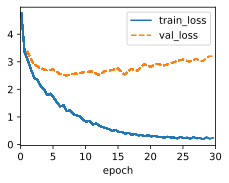

In [13]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


#### Prediction

In [27]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', 'suis', 'de', 'la', 'partie', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
